## functions

In [1]:
import pandas as pd
import numpy as np
import os
import gc

import addict
import lightgbm as lgb

def save_dataframe(path, dataframe):
    np.save(path + ".data", dataframe.values)
    np.save(path + ".header", dataframe.columns)


def load_dataframe(path):
    data = np.load(path + ".data.npy")
    header = np.load(path + ".header.npy")
    return pd.DataFrame(data=data, columns=header)


def save_dataframe32(path, dataframe, keep=[]):
    col64 = [col_ for col_ in dataframe.columns if col_ in keep]
    col32 = [col_ for col_ in dataframe.columns if col_ not in keep]
    dataframe64 = dataframe[col64]
    dataframe32 = dataframe[col32]
    np.save(path + ".data64", dataframe64.values)
    np.save(path + ".header64", col64)
    np.save(path + ".data32", dataframe32.values.astype(np.float32))
    np.save(path + ".header32", col32)


def load_dataframe32(path, nrows=None):
    path_data32 = path + ".data32.npy"
    path_header32 = path + ".header32.npy"
    path_data64 = path + ".data64.npy"
    path_header64 = path + ".header64.npy"
    result = pd.DataFrame()
    if os.path.exists(path_data32):
        data32 = np.load(path_data32)
        header32 = np.load(path_header32)
        df32 = pd.DataFrame(data=data32, columns=header32)
        result = pd.concat([result, df32], axis=1)
    if os.path.exists(path_data64):
        data64 = np.load(path_data64)
        header64 = np.load(path_header64)
        df64 = pd.DataFrame(data=data64, columns=header64)
        result = pd.concat([result, df64], axis=1)
    if nrows and nrows > 0:
        return result.head(nrows)
    return result

In [2]:
from sklearn.metrics import roc_auc_score

## feature group & model structure

In [3]:
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from string import punctuation
from os import listdir
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import numpy as np

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from sklearn.datasets import load_iris
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import sys
import time
import lightgbm as lgb

from bayes_opt import BayesianOptimization
from scipy.stats import pearsonr

import warnings
import lightgbm as lgb

warnings.filterwarnings("ignore")

C:\Anaconda2\envs\python3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, Callback
from keras.wrappers.scikit_learn import KerasClassifier

In [5]:
def get_header(feature_name, length=4):
    for char in "0123456789":
        feature_name = feature_name.replace(char, "")
    items = feature_name.split("_")
    if len(items) < length + 1:
        return "short"
    return "_".join(items[:length])

def create_feature_info(features):
    features_info = pd.DataFrame({
        "feature_idx": np.arange(len(features)),
        "feature_name": features
    })

    features_info["feature_header"] = features_info.feature_name.apply(get_header)
    features_info["group_size"] = features_info.feature_header.map(features_info.feature_header.value_counts())
    features_info.loc[features_info.group_size < 10, "feature_header"] = "short"
    features_info["group_size"] = features_info.feature_header.map(features_info.feature_header.value_counts())
    return features_info

In [6]:
def create_scaler_stack(features_info):
    return {key: StandardScaler() for key in features_info.feature_header.unique()}

def create_feature_stack(feature_info):
    return {key: list(features_info[features_info.feature_header == key].feature_name) for key in features_info.feature_header.unique()}

def replace_nan(X):
    X = X.copy()
    X[np.isnan(X)] = 0
    X[X == np.Inf] = X[X != np.Inf].max()
    X[X == -np.Inf] = X[X != -np.Inf].min()
    # print(X.shape, X.max(), X.min())
    return X

In [7]:
def less_ftr(input_dim):
    return int(np.log(input_dim) * np.sqrt(input_dim))

def create_model(feature_stack):
    input_lyr = [Input(shape=[len(ftrs_)], name=key_) for key_, ftrs_ in feature_stack.items()]
    dense0_lyr = [Dense(less_ftr(len(ftrs_)), activation="relu")(input_lyr[i]) for i, (key_, ftrs_) in enumerate(feature_stack.items())]
    main0_lyr = concatenate(dense0_lyr)
    drop0_lyr = Dropout(.75)(main0_lyr)
    main1_lyr = Dense(128, activation="relu")(drop0_lyr)
    output = Dense(1, activation="sigmoid")(main1_lyr)
    model = Model(input_lyr, output)
    model.compile(loss="binary_crossentropy", optimizer="adam")
    return model

def create_model(feature_stack):
    input_lyr = [Input(shape=[len(ftrs_)], name=key_) for key_, ftrs_ in feature_stack.items()]
    dense0_lyr = [Dense(less_ftr(len(ftrs_)), activation="relu")(input_lyr[i]) for i, (key_, ftrs_) in enumerate(feature_stack.items())]
    main0_lyr = concatenate(dense0_lyr)
    drop0_lyr = Dropout(.8)(main0_lyr)
    main1_lyr = Dense(128, activation="relu")(drop0_lyr)
    main2_lyr = Dense(64, activation="sigmoid")(main1_lyr)
    drop1_lyr = Dropout(.1)(main2_lyr)
    output = Dense(1, activation="sigmoid")(drop1_lyr)
    model = Model(input_lyr, output)
    model.compile(loss="binary_crossentropy", optimizer="adam")
    return model


def create_model(feature_stack):
    input_lyr = [Input(shape=[len(ftrs_)], name=key_) for key_, ftrs_ in feature_stack.items()]
    dense0_lyr = [Dense(less_ftr(len(ftrs_)), activation="relu")(input_lyr[i]) for i, (key_, ftrs_) in enumerate(feature_stack.items())]
    main0_lyr = concatenate(dense0_lyr)
    drop0_lyr = Dropout(.92)(main0_lyr)
    main1_lyr = Dense(156, activation="relu")(drop0_lyr)
    output = Dense(1, activation="sigmoid")(main1_lyr)
    model = Model(input_lyr, output)
    model.compile(loss="binary_crossentropy", optimizer="adam")
    return model

In [8]:
from functools import partial

features = list(np.load('./neptune-features/features_246008_1174_0.npy'))
features_nmf = list(np.load('./nmf-features/features-part2.npy'))

features_info = create_feature_info(features + features_nmf)
features_stack = create_feature_stack(features_info)
create_model_fixed = partial(create_model, features_stack)

In [9]:
model = create_model(features_stack)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
short (InputLayer)              (None, 274)          0                                            
__________________________________________________________________________________________________
NAME_EDUCATION_TYPE_CODE (Input (None, 90)           0                                            
__________________________________________________________________________________________________
NAME_FAMILY_STATUS_NAME (InputL (None, 90)           0                                            
__________________________________________________________________________________________________
NAME_FAMILY_STATUS_CODE (InputL (None, 90)           0                                            
__________________________________________________________________________________________________
NAME_EDUCA

## check data

In [26]:
# nrows = None  
nrows = 1000

features = list(np.load('./neptune-features/features_246008_1174_0.npy'))
features_nmf = list(np.load('./nmf-features/features-part2.npy'))

features_info = create_feature_info(features + features_nmf)
features_stack = create_feature_stack(features_info)
create_model_fixed = partial(create_model, features_stack)

train_app = load_dataframe32("./bindata/application_train")
auc_valid_stack = []
pred_valid_stack = []
pred_test_stack = []

for i in range(5):
    break
    train_idx_fn = "./neptune-features/train_idx_{}.npy".format(i)
    valid_idx_fn = "./neptune-features/valid_idx_{}.npy".format(i)

    train_offset, valid_offset, test_offset = i * 4, i * 4 + 1, i * 4 + 3
    
    train_data_fn = "./neptune-features/data_246009_1174_{}".format(train_offset)
    valid_data_fn = "./neptune-features/data_61502_1174_{}".format(valid_offset)
    test_data_fn = "./neptune-features/data_48744_1174_{}".format(test_offset)

    if i == 0:
        train_data_fn = train_data_fn.replace("246009", "246008")
        valid_data_fn = valid_data_fn.replace("61502", "61503")
        
    train_nmf_fn = "./nmf-features/nmf_246009_1174_{}".format(train_offset)
    valid_nmf_fn = "./nmf-features/nmf_61502_1174_{}".format(valid_offset)
    test_nmf_fn = "./nmf-features/nmf_48744_1174_{}".format(test_offset)

    if i == 0:
        train_nmf_fn = train_nmf_fn.replace("246009", "246008")
        valid_nmf_fn = valid_nmf_fn.replace("61502", "61503")
    
    gc.collect()

    train_idx = np.load(train_idx_fn)
    valid_idx = np.load(valid_idx_fn)
    
    if nrows:
        train_idx, valid_idx = train_idx[:nrows].copy(), valid_idx[:nrows].copy()

    train_data = load_dataframe32(train_data_fn, nrows)
    valid_data = load_dataframe32(valid_data_fn, nrows)
    test_data = load_dataframe32(test_data_fn, nrows)
    
    train_nmf = load_dataframe32(train_nmf_fn, nrows)
    valid_nmf = load_dataframe32(valid_nmf_fn, nrows)
    test_nmf = load_dataframe32(test_nmf_fn, nrows)
    
    train_data = pd.concat([train_data, train_nmf], axis=1)
    valid_data = pd.concat([valid_data, valid_nmf], axis=1)
    test_data = pd.concat([test_data, test_nmf], axis=1) 
    
    gc.collect()
    
    scalar_stack = create_scaler_stack(features_info)
    X_train_mult = {key: scalar_stack[key].fit_transform(replace_nan(train_data[items].values)) for key, items in features_stack.items()}
    X_valid_mult = {key: scalar_stack[key].transform(replace_nan(valid_data[items].values)) for key, items in features_stack.items()}
    X_test_mult = {key: scalar_stack[key].transform(replace_nan(test_data[items].values)) for key, items in features_stack.items()}

    y_train = train_app.loc[train_idx].TARGET
    y_valid = train_app.loc[valid_idx].TARGET
    
    print(train_idx_fn, valid_idx_fn)
    print(train_idx.shape, valid_idx.shape)
    print(train_data_fn, train_data.shape)
    print(valid_data_fn, valid_data.shape)
    print(test_data_fn, test_data.shape)

    print(train_nmf_fn, train_nmf.shape)
    print(valid_nmf_fn, valid_nmf.shape)
    print(test_nmf_fn, test_nmf.shape)

./neptune-features/train_idx_0.npy ./neptune-features/valid_idx_0.npy
(1000,) (1000,)
./neptune-features/data_246008_1174_0 (1000, 1666)
./neptune-features/data_61503_1174_1 (1000, 1666)
./neptune-features/data_48744_1174_3 (1000, 1666)
./nmf-features/nmf_246008_1174_0 (1000, 492)
./nmf-features/nmf_61503_1174_1 (1000, 492)
./nmf-features/nmf_48744_1174_3 (1000, 492)
./neptune-features/train_idx_1.npy ./neptune-features/valid_idx_1.npy
(1000,) (1000,)
./neptune-features/data_246009_1174_4 (1000, 1666)
./neptune-features/data_61502_1174_5 (1000, 1666)
./neptune-features/data_48744_1174_7 (1000, 1666)
./nmf-features/nmf_246009_1174_4 (1000, 492)
./nmf-features/nmf_61502_1174_5 (1000, 492)
./nmf-features/nmf_48744_1174_7 (1000, 492)
./neptune-features/train_idx_2.npy ./neptune-features/valid_idx_2.npy
(1000,) (1000,)
./neptune-features/data_246009_1174_8 (1000, 1666)
./neptune-features/data_61502_1174_9 (1000, 1666)
./neptune-features/data_48744_1174_11 (1000, 1666)
./nmf-features/nmf_246

## early stop

In [10]:
class roc_auc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        # y_pred = self.model.predict_proba(self.x, verbose=0)
        y_pred = self.model.predict(self.x, verbose=0)
        roc = roc_auc_score(self.y, y_pred)
        logs['roc_auc'] = roc_auc_score(self.y, y_pred)
        logs['norm_gini'] = ( roc_auc_score(self.y, y_pred) * 2 ) - 1

        # y_pred_val = self.model.predict_proba(self.x_val, verbose=0)
        y_pred_val = self.model.predict(self.x_val, verbose=0)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        logs['roc_auc_val'] = roc_auc_score(self.y_val, y_pred_val)
        logs['norm_gini_val'] = ( roc_auc_score(self.y_val, y_pred_val) * 2 ) - 1

        # print('\rroc_auc: %s - roc_auc_val: %s - norm_gini: %s - norm_gini_val: %s' % (str(round(roc,5)),str(round(roc_val,5)),str(round((roc*2-1),5)),str(round((roc_val*2-1),5))), end=10*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

## keras

In [ ]:
nrows = None  
# nrows = 1000
run=1

features = list(np.load('./neptune-features/features_246008_1174_0.npy'))
features_nmf = list(np.load('./nmf-features/features-part2.npy'))

features_info = create_feature_info(features + features_nmf)
features_stack = create_feature_stack(features_info)
create_model_fixed = partial(create_model, features_stack)

train_app = load_dataframe32("./bindata/application_train")
auc_valid_stack = []
pred_valid_stack = []
pred_test_stack = []

for i in range(5):
    train_idx_fn = "./neptune-features/train_idx_{}.npy".format(i)
    valid_idx_fn = "./neptune-features/valid_idx_{}.npy".format(i)

    train_offset, valid_offset, test_offset = i * 4, i * 4 + 1, i * 4 + 3
    
    train_data_fn = "./neptune-features/data_246009_1174_{}".format(train_offset)
    valid_data_fn = "./neptune-features/data_61502_1174_{}".format(valid_offset)
    test_data_fn = "./neptune-features/data_48744_1174_{}".format(test_offset)

    if i == 0:
        train_data_fn = train_data_fn.replace("246009", "246008")
        valid_data_fn = valid_data_fn.replace("61502", "61503")
        
    train_nmf_fn = "./nmf-features/nmf_246009_1174_{}".format(train_offset)
    valid_nmf_fn = "./nmf-features/nmf_61502_1174_{}".format(valid_offset)
    test_nmf_fn = "./nmf-features/nmf_48744_1174_{}".format(test_offset)

    if i == 0:
        train_nmf_fn = train_nmf_fn.replace("246009", "246008")
        valid_nmf_fn = valid_nmf_fn.replace("61502", "61503")
    
    gc.collect()

    train_idx = np.load(train_idx_fn)
    valid_idx = np.load(valid_idx_fn)
    
    if nrows:
        train_idx, valid_idx = train_idx[:nrows].copy(), valid_idx[:nrows].copy()

    train_data = load_dataframe32(train_data_fn, nrows)
    valid_data = load_dataframe32(valid_data_fn, nrows)
    test_data = load_dataframe32(test_data_fn, nrows)
    
    train_nmf = load_dataframe32(train_nmf_fn, nrows)
    valid_nmf = load_dataframe32(valid_nmf_fn, nrows)
    test_nmf = load_dataframe32(test_nmf_fn, nrows)
    
    train_data = pd.concat([train_data, train_nmf], axis=1)
    valid_data = pd.concat([valid_data, valid_nmf], axis=1)
    test_data = pd.concat([test_data, test_nmf], axis=1) 
    
    gc.collect()
    
    scalar_stack = create_scaler_stack(features_info)
    X_train_mult = {key: scalar_stack[key].fit_transform(replace_nan(train_data[items].values)) for key, items in features_stack.items()}
    X_valid_mult = {key: scalar_stack[key].transform(replace_nan(valid_data[items].values)) for key, items in features_stack.items()}
    X_test_mult = {key: scalar_stack[key].transform(replace_nan(test_data[items].values)) for key, items in features_stack.items()}

    y_train = train_app.loc[train_idx].TARGET
    y_valid = train_app.loc[valid_idx].TARGET
    gc.collect()
    
    print(train_idx_fn, valid_idx_fn)
    print(train_idx.shape, valid_idx.shape)
    print(train_data_fn, train_data.shape)
    print(valid_data_fn, valid_data.shape)
    print(test_data_fn, test_data.shape)

    print(train_nmf_fn, train_nmf.shape)
    print(valid_nmf_fn, valid_nmf.shape)
    print(test_nmf_fn, test_nmf.shape)
    
    callbacks = [
        roc_auc_callback(
            training_data=(X_train_mult, y_train),
            validation_data=(X_valid_mult, y_valid)
        ),  # call this before EarlyStopping
        EarlyStopping(monitor='norm_gini_val', patience=20, mode='max', verbose=1),
        CSVLogger('keras-5fold-run-01-v1-epochs-fold-{}.log'.format(i + 1), separator=',', append=False),
        ModelCheckpoint(
            '029-keras-5fold-run-01-v1-fold-' + str('%02d' % (i + 1)) + '-run-' + str('%02d' % (run + 1)) + '.check',
            monitor='norm_gini_val', mode='max', # mode must be set to max or Keras will be confused
            save_best_only=True,
            verbose=0
        )
    ]

    np.random.seed(i)
    # create_model(features_stack)
    estimator = KerasClassifier(
        build_fn=create_model_fixed,
        epochs=5000,
        batch_size=200,
        validation_data=(X_valid_mult, y_valid),
        verbose=0,
        shuffle=True,
        callbacks=callbacks
    )
    estimator.fit(X_train_mult, y_train)
    
    del estimator
    estimator = load_model('029-keras-5fold-run-01-v1-fold-' + str('%02d' % (i + 1)) + '-run-' + str('%02d' % (run + 1)) + '.check')
    
    pred_valid = estimator.predict(X_valid_mult)
    pred_valid_stack.append(pred_valid)
    
    auc = roc_auc_score(y_valid, pred_valid)
    auc_valid_stack.append(auc)
    print("fold-{},auc:{}".format(i, auc))

    pred_test = estimator.predict(X_test_mult)
    pred_test_stack.append(pred_test)
    
    # break
    
print("kfold-auc, avg:{:.4}, std:{:.2}".format(np.mean(auc_valid_stack), np.std(auc_valid_stack)))

./neptune-features/train_idx_0.npy ./neptune-features/valid_idx_0.npy
(246008,) (61503,)
./neptune-features/data_246008_1174_0 (246008, 1666)
./neptune-features/data_61503_1174_1 (61503, 1666)
./neptune-features/data_48744_1174_3 (48744, 1666)
./nmf-features/nmf_246008_1174_0 (246008, 492)
./nmf-features/nmf_61503_1174_1 (61503, 492)
./nmf-features/nmf_48744_1174_3 (48744, 492)


## save oof & submission

In [33]:
def calculate_rank(predictions):
    rank = (1 + pd.Series(predictions).rank().values) / (predictions.shape[0] + 1)
    return rank

pred_target = sum([calculate_rank(np.array([r_[0] for r_ in p_])) for p_ in pred_test_stack]) / 5

pred_sample = pd.read_csv("./result/submission-022-blend08.csv")
pred_sample["TARGET"] = pred_target

pred_sample.to_csv("./result/submission-029-keras.csv", index=False)

In [35]:
oof_pred = np.zeros(train_app.shape[0])

for i in range(5):
    valid_idx_fn = "./neptune-features/valid_idx_{}.npy".format(i)
    valid_idx = np.load(valid_idx_fn)
    oof_pred[valid_idx] = np.array([r_[0] for r_ in pred_valid_stack[i]])
    
oof_df = train_app[["SK_ID_CURR"]].copy()
oof_df["SK_ID_CURR"] = oof_df.SK_ID_CURR.astype("int")
oof_df["oof_pred"] = oof_pred
oof_df.to_csv("./oof-result/oof-029-keras.csv", index=False)

In [37]:
log25 = pd.read_csv("./keras-5fold-run-01-v1-epochs-backup.log")
log29 = pd.read_csv("./keras-5fold-run-01-v1-epochs.log")

## learning curve

In [38]:
log25.head()

,epoch,loss,norm_gini,norm_gini_val,roc_auc,roc_auc_val,val_loss
0,0,0.277088,0.527259,0.512578,0.763630,0.756289,0.273774
1,1,0.255766,0.545393,0.529079,0.772697,0.764539,0.246804
2,2,0.250860,0.553660,0.538558,0.776830,0.769279,0.246132
3,3,0.248426,0.561044,0.544961,0.780522,0.772480,0.245528
4,4,0.246335,0.565296,0.547705,0.782648,0.773852,0.244124


In [39]:
log29.head()

,epoch,loss,norm_gini,norm_gini_val,roc_auc,roc_auc_val,val_loss
0,0,0.275452,0.531320,0.520926,0.765660,0.760463,0.252387
1,1,0.254512,0.546526,0.535531,0.773263,0.767765,0.248168
2,2,0.249779,0.556002,0.542251,0.778001,0.771125,0.245364
3,3,0.247877,0.561307,0.544036,0.780654,0.772018,0.243007
4,4,0.246241,0.565825,0.547428,0.782912,0.773714,0.242151


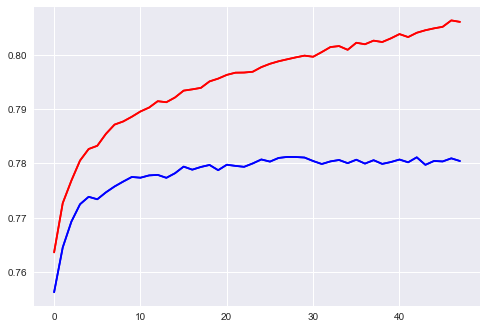

In [41]:
plt.plot(log25.epoch, log25.roc_auc, c="r")
plt.plot(log25.epoch, log25.roc_auc_val, c="b")
plt.show()

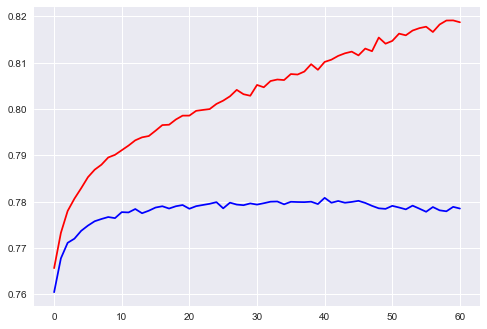

In [43]:
plt.plot(log29.epoch, log29.roc_auc, c="r")
plt.plot(log29.epoch, log29.roc_auc_val, c="b")
plt.show()

## mix

In [ ]:
oof_lgb024 = pd.read_csv("./oof-result/oof-024-first.csv")
oof_keras025 = pd.read_csv("./oof-result/oof-024-keras01.csv")


oof_df["oof_lgb028"] = oof_df["oof_pred"]
oof_df["oof_lgb024"] = oof_lgb024["oof_pred"]
oof_df["oof_keras025"] = oof_keras025["oof_pred"]
oof_df["TARGET"] = train_app["TARGET"]

In [ ]:
def rank_avg_and_show_oof_auc(oof_df, columns=["oof_lgb028", "oof_lgb024", "oof_keras025"], weights=[.33, .33, .34]):
    auc_valid_stack = []
    for i in range(5):
        train_idx_fn = "./neptune-features/train_idx_{}.npy".format(i)
        valid_idx_fn = "./neptune-features/valid_idx_{}.npy".format(i)

        train_offset, valid_offset, test_offset = i * 4, i * 4 + 1, i * 4 + 3

        train_data_fn = "./neptune-features/data_246009_1174_{}".format(train_offset)
        valid_data_fn = "./neptune-features/data_61502_1174_{}".format(valid_offset)
        test_data_fn = "./neptune-features/data_48744_1174_{}".format(test_offset)

        if i == 0:
            train_data_fn = train_data_fn.replace("246009", "246008")
            valid_data_fn = valid_data_fn.replace("61502", "61503")

        gc.collect()

        train_idx = np.load(train_idx_fn)
        valid_idx = np.load(valid_idx_fn)

        fold_data = oof_df.loc[valid_idx]
        fold_target = fold_data.TARGET
        
        fold_pred = np.zeros(fold_data.shape[0])
        for col_, w_ in zip(columns, weights):
            fold_pred += w_ * calculate_rank(oof_df.loc[valid_idx][col_])

        auc = roc_auc_score(fold_target, fold_pred)
        auc_valid_stack.append(auc)
        print("fold-{},auc:{}".format(i, auc))

    print("kfold-auc, avg:{:.8}, std:{:.2}".format(np.mean(auc_valid_stack), np.std(auc_valid_stack)))

In [ ]:
rank_avg_and_show_oof_auc(oof_df, weights=[.08, .79, .13])

In [ ]:
rank_avg_and_show_oof_auc(oof_df, weights=[.09, .79, .12])

In [ ]:
rank_avg_and_show_oof_auc(oof_df, weights=[.08, .8, .12])

In [ ]:
rank_avg_and_show_oof_auc(oof_df, weights=[.07, .81, .12])

In [ ]:
rank_avg_and_show_oof_auc(oof_df, weights=[.06, .82, .12])

In [ ]:
rank_avg_and_show_oof_auc(oof_df, weights=[.1, .78, .12])

In [ ]:
rank_avg_and_show_oof_auc(oof_df)

In [ ]:
rank_avg_and_show_oof_auc(oof_df, weights=[.1, .8, .1])

In [ ]:
rank_avg_and_show_oof_auc(oof_df, weights=[.2, .6, .2])

In [ ]:
rank_avg_and_show_oof_auc(oof_df, weights=[.1, .7, .2])

In [ ]:
oof_df.head()